In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns

In [5]:
# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
# get column density NH
NH_data16 = np.array(data16['NH'])

In [6]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=472). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=663). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1717). ']


In [7]:
# returns array of ( min <= z < max )
def GetRedshiftsInRange(
        zDict,   # dictionary of ID and z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
        printLength=True
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        mask = (zDict['z'] >= min) & (zDict['z'] < max)
    else: 
        mask = (zDict['z'] > min) & (zDict['z'] <= max)
    # idolate ID and z
    inRange = {
        'ID' : zDict['ID'][mask] ,
        'z'  : zDict['z'] [mask]
    }
    if(printLength) : 
        if(incusiveMin): 
            print(min, '<= z < ', max, ': ', len(inRange['ID']))
        else:
             print(min, '< z <= ', max, ': ', len(inRange['ID']))       
    return(inRange)

# get redshifts
zDict_all = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

zDict_split = {
    '$0 < z \leq 1$'   : GetRedshiftsInRange(zDict_all,          max=1  ),
    '$1 < z \leq 1.5$' : GetRedshiftsInRange(zDict_all, min=1,   max=1.5),
    '$1.5 < z \leq 2$' : GetRedshiftsInRange(zDict_all, min=1.5, max=2  ),
    '$2 < z \leq 3$'   : GetRedshiftsInRange(zDict_all, min=2,   max=3  ),
    '$3 < z \leq 6$'   : GetRedshiftsInRange(zDict_all, min=3           )
}

Cropped:  ['ID', 'z']
Number of redshifts: 485793
0 < z <=  1 :  211361
1 < z <=  1.5 :  95993
1.5 < z <=  2 :  57518
2 < z <=  3 :  66963
3 < z <=  99 :  44466


# Get NH for AGN

In [33]:
def GetNH(id_agn, id_catalog, NH_catalog) : 
    # match again with catalog 
    idmatch_onagn, idmatch_oncat = match.match(id_agn, id_catalog) 
    # get NH values
    agn_NH = (NH_catalog[idmatch_oncat] > -99 )
    # get AGN info for objects with NH
    agn_withNH = {
        'ID' : id_catalog[idmatch_oncat][agn_NH],
        'NH' : np.log10(NH_catalog[idmatch_oncat][agn_NH] * (1E22)  )# scaling factor and then log scale
    }
    # get remaining AGN
    agn_withoutNH = {
        'ID' : np.setdiff1d(id_agn, agn_withNH['ID'], assume_unique=True)
    }
    return(agn_withNH,agn_withoutNH)

# initialize dicts
AGNinfo_dict_withNH = {}
AGNinfo_dict_withoutNH = {}
# get NH for each color RED/GRN/BLU
for key, val in agnIDs_dict.items() : 
    AGNinfo_dict_withNH[key], AGNinfo_dict_withoutNH[key] = GetNH(agnIDs_dict[key], id_data16, NH_data16)

C:\Users\polar\AppData\Local\Temp\ipykernel_9576\1653152819.py:9: RuntimeWarning: divide by zero encountered in log10
  'NH' : np.log10(NH_catalog[idmatch_oncat][agn_NH] * (1E22)  )# scaling factor and then log scale


In [71]:
def NH_Histogram_ax(
    ax,
    nh,
    c='black',
    h=400,          # plot height 
    bins=np.arange(21.5,24.5,0.25), # histogram bins
    zfullText=''
):
    ax.hist(nh,bins=bins,histtype='bar',color=c)
    # plot settings
    ax.set_ylim(ymin=0, ymax=h)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    adp.AddText_n_ax(ax,len(nh))
    adp.AddText_z_ax(ax,zfullText)
    adp.MeanLineForHist_ax(ax=ax,x=nh,c=c,xtext=0.995,ytext=0.875,horizAlign='right' ,pre='')

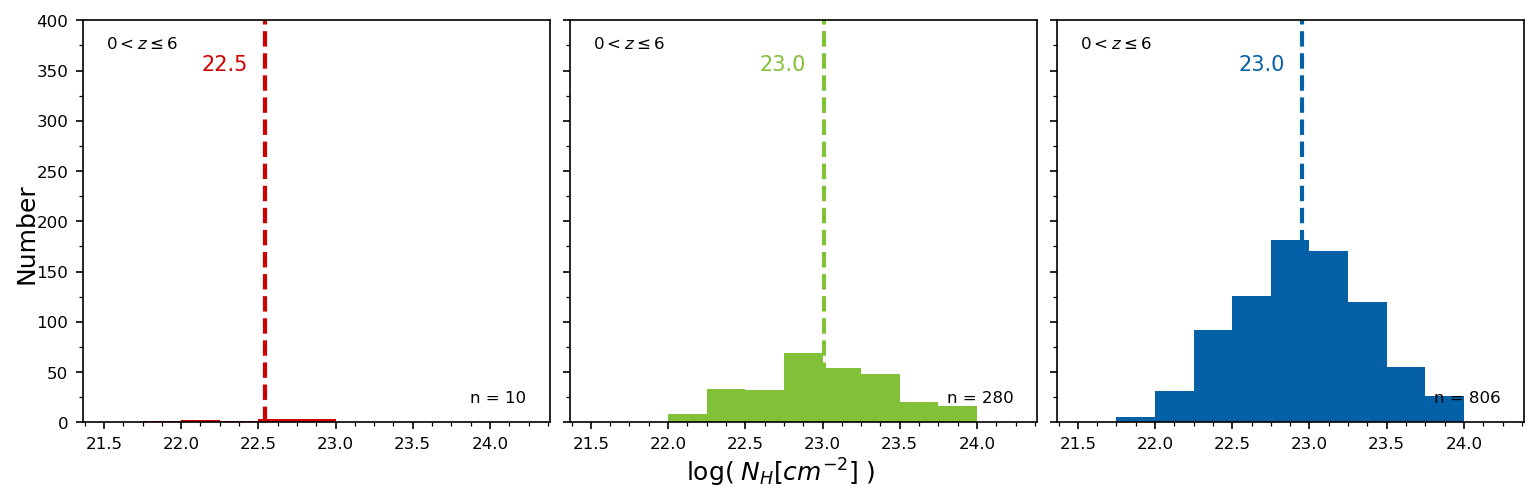

In [72]:
def NH_Histogram(
    AGNinfo_dict_withNH,
    orientVertical=False,
    save=''
) :
    fig, ax = adp.ByZ_SetupFig(
        n = len(AGNinfo_dict_withNH.keys()),
        orientVertical=orientVertical,
        figsizeConstVal=3
    )

    colors = [adp.c_ir, adp.c_ir_xray, adp.c_xray]
    i=0
    for keyColor, valDict in AGNinfo_dict_withNH.items() :
        NH_Histogram_ax(
            ax=ax[i],
            nh=valDict['NH'][np.isfinite(valDict['NH'])],
            c=colors[i],
            zfullText='$0 < z \leq 6$'
        )
        i+=1

    xpos=(0.5, -0.05)
    ypos=(-0.01,  0.5)
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; N_H [cm^{-2}] \;)$',
        'Number',
        save, xpos, ypos
    )


NH_Histogram(
    AGNinfo_dict_withNH,
    save=adp.path_fig+'\\v2_hist_NH_tricolor_zAll.png'
)



# Color-Color Diagram

In [38]:
def ReduceColorDict(agnDict) : 
    # agnDict = { RED : {...}, GRN : {...}, BLU : {...}} --> merge dicts from keys 
    agnDict_reduced = {}
    # for each 
    for colorKey, dataDict in agnDict.items() : 
        for key, data in dataDict.items() : 
            if(key in agnDict_reduced): 
                agnDict_reduced[key] = np.concatenate((agnDict_reduced[key], data))
            else: 
                agnDict_reduced[key] = data
    # return dict
    return(agnDict_reduced)
    
AGNinfo_dict_withNH_reduced    = ReduceColorDict(AGNinfo_dict_withNH)
AGNinfo_dict_withoutNH_reduced = ReduceColorDict(AGNinfo_dict_withoutNH)


def CheckReducedMatch(agnDict_reduced, agnDict) : 
    allGood = True
    for key in agnDict_reduced.keys() : 
        isThisGood = np.array_equal( 
            agnDict_reduced[key], 
            np.concatenate((agnDict['RED'][key],agnDict['GRN'][key],agnDict['BLU'][key]))
        )
        if(not isThisGood) :
            print('\tFailure with:', key)
        allGood = allGood & isThisGood 
    return(allGood)

print('Reduced Match (withNH):\t',   CheckReducedMatch(AGNinfo_dict_withNH_reduced,AGNinfo_dict_withNH))
print('Reduced Match (noNH):\t',     CheckReducedMatch(AGNinfo_dict_withoutNH_reduced,AGNinfo_dict_withoutNH))

Reduced Match (withNH):	 True
Reduced Match (noNH):	 True
[22.99913  21.986773 22.499687 ... 22.389166      -inf 22.901459]


In [39]:
def IDtoIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to get IRAC channels 
    key_cat, key_agn = match.match(id_catalog, id_agn)
    # calculate colors
    x = np.array(adp.IRACx(ch1[key_cat], ch3[key_cat]))
    y = np.array(adp.IRACy(ch2[key_cat], ch4[key_cat]))
    return(x, y)

# get colors
AGNinfo_dict_withNH_reduced['x'],    AGNinfo_dict_withNH_reduced['y']    = IDtoIRACcolors(AGNinfo_dict_withNH_reduced['ID'], id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 )
AGNinfo_dict_withoutNH_reduced['x'], AGNinfo_dict_withoutNH_reduced['y'] = IDtoIRACcolors(AGNinfo_dict_withoutNH_reduced['ID'], id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 )

[22.99913  21.986773 22.499687 ... 22.389166      -inf 22.901459]


In [22]:
def PlotColorColorNH_ax(
        ax,                     # axis for plotting
        x0,y0,                  # x and y coordinants to be gray crosses
        x,y,                    # x and y coordinants to fit colorbar to 
        nh, vmin, vmax,          # column density 
        showCrosses=True,       # show the 0 coordinants 
        zfullText=''            # redshift range string
):
    # plot data
    if(showCrosses):
        ax.scatter(x0, y0, marker='x', s=4, c='lightgrey', label='No $N_H$ measurement (n='+str(len(x0))+')')
    ax.scatter(x, y, marker='D', s=3, c=nh, cmap=plt.cm.get_cmap('copper',9), vmin=vmin, vmax=vmax,  label='$N_H$ (n='+str(len(x))+')')   
    # decorations
    adp.PlotDonleyWedge_ax(ax)
    adp.AddText_z_ax(ax, zfullText)
    if(showCrosses):
        adp.AddText_n_ax(ax,len(x0)+len(x), pre='$\mathrm{N_{total}}$ = ')
    else:
        adp.AddText_n_ax(ax,len(x))
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([-0.7,1.0])
    ax.set_ylim([-0.7,1.0])
    ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

21.755875
23.999565
[22.99913  21.986773 22.499687 ... 22.389166      -inf 22.901459]


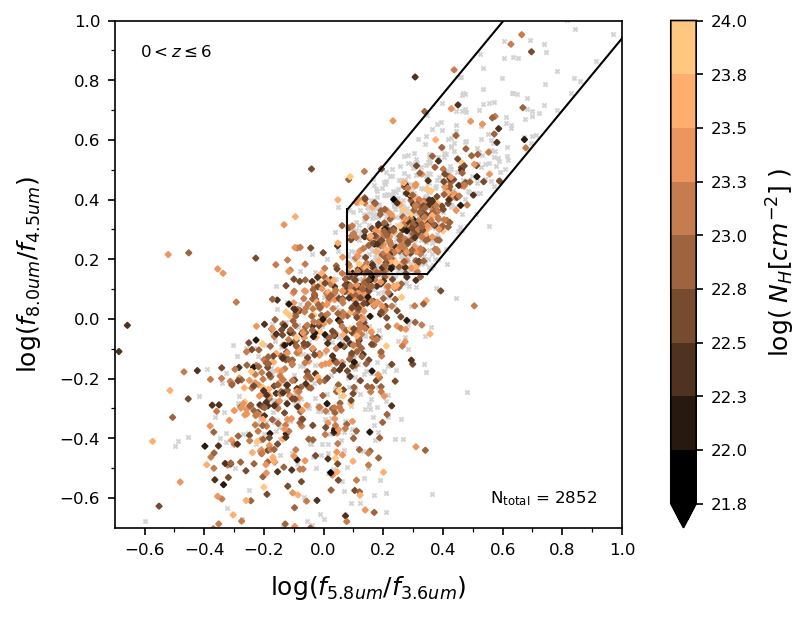

In [64]:
def PlotColorColorNH(
    withNH,
    withoutNH,
    save=''
):
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')

    # determine colorbar values for NH
    nh = withNH['NH']
    nh_min = np.nanmin(nh[np.isfinite(nh)])
    nh_max = np.nanmax(nh)
    # nh[nh>nh_max] = nh_max # exclude outliers 

    print(nh_min)
    print(nh_max)
    print(nh)
    
    PlotColorColorNH_ax(
        ax,
        x0= withoutNH['x'],
        y0= withoutNH['y'],
        x = withNH['x'],
        y = withNH['y'],
        nh=nh, vmin=nh_min, vmax=nh_max,
        showCrosses=True,
        zfullText='$0 < z \leq 6$'
    )

    SED.PlotColorbar_ax(
        ax=ax, 
        cmap=plt.cm.get_cmap('copper',9), 
        min=nh_min, 
        max=nh_max, 
        n_ticks=10, 
        label='$\log( \; N_H [cm^{-2}] \;)$',
        location='right',
        extend='min'
    )
    # lables 
    plt.xlabel('$\log(f_{5.8um}/f_{3.6um})$')
    plt.ylabel('$\log(f_{8.0um}/f_{4.5um})$')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

PlotColorColorNH(
    AGNinfo_dict_withNH_reduced,
    AGNinfo_dict_withoutNH_reduced,
    save=adp.path_fig + '\\v2_colorDiagram_NH_zAll.png'
)

# By Z

In [24]:
def GetAGNinZrange(agnDict, zDict_split, printLengths=True):
    agnByZ = {}
    # for each redshft range 
    for key,zdata in zDict_split.items() :
        # match IDs
        onAGN, onZ = match.match(agnDict['ID'], zdata['ID'])
        # setup dict entry 
        agnByZ[key] = {}
        agnByZ[key]['z'] = zdata['z'][onZ]
        # get data
        for agnkey, agndata in agnDict.items() :
            if(isinstance(agndata, tuple)):
                agnByZ[key][agnkey] = agndata[0][onAGN] 
            else: 
                agnByZ[key][agnkey] = agndata[onAGN]
        # print
        if(printLengths) :
            print(key, ': ', len(agnByZ[key]['z']))
    return(agnByZ)

AGNinfo_dict_withNH_byZ    = GetAGNinZrange(AGNinfo_dict_withNH_reduced,    zDict_split)
print('~~~')
AGNinfo_dict_withoutNH_byZ = GetAGNinZrange(AGNinfo_dict_withoutNH_reduced, zDict_split)

$0 < z \leq 1$ :  478
$1 < z \leq 1.5$ :  590
$1.5 < z \leq 2$ :  443
$2 < z \leq 3$ :  452
$3 < z \leq 6$ :  81
~~~
$0 < z \leq 1$ :  105
$1 < z \leq 1.5$ :  174
$1.5 < z \leq 2$ :  203
$2 < z \leq 3$ :  236
$3 < z \leq 6$ :  90
